In [2]:
from setup   import *
from netCDF4 import Dataset
import glob
from joint_flight.results import *

No environment variable JOINT_FLIGHT_PATH found. Will look in ../joint_flight/..  for the joint flight data.


(0, 10)

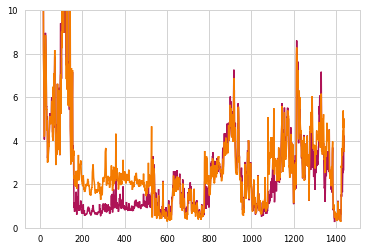

In [3]:
diagnostics_8ca = results["8_column_aggregate"]["diagnostics"]
diagnostics_lpa = results["large_plate_aggregate"]["diagnostics"]
plt.plot(diagnostics_8ca[:, 2])
plt.plot(diagnostics_lpa[:, 2])
plt.ylim([0, 10])

## Fitted observations

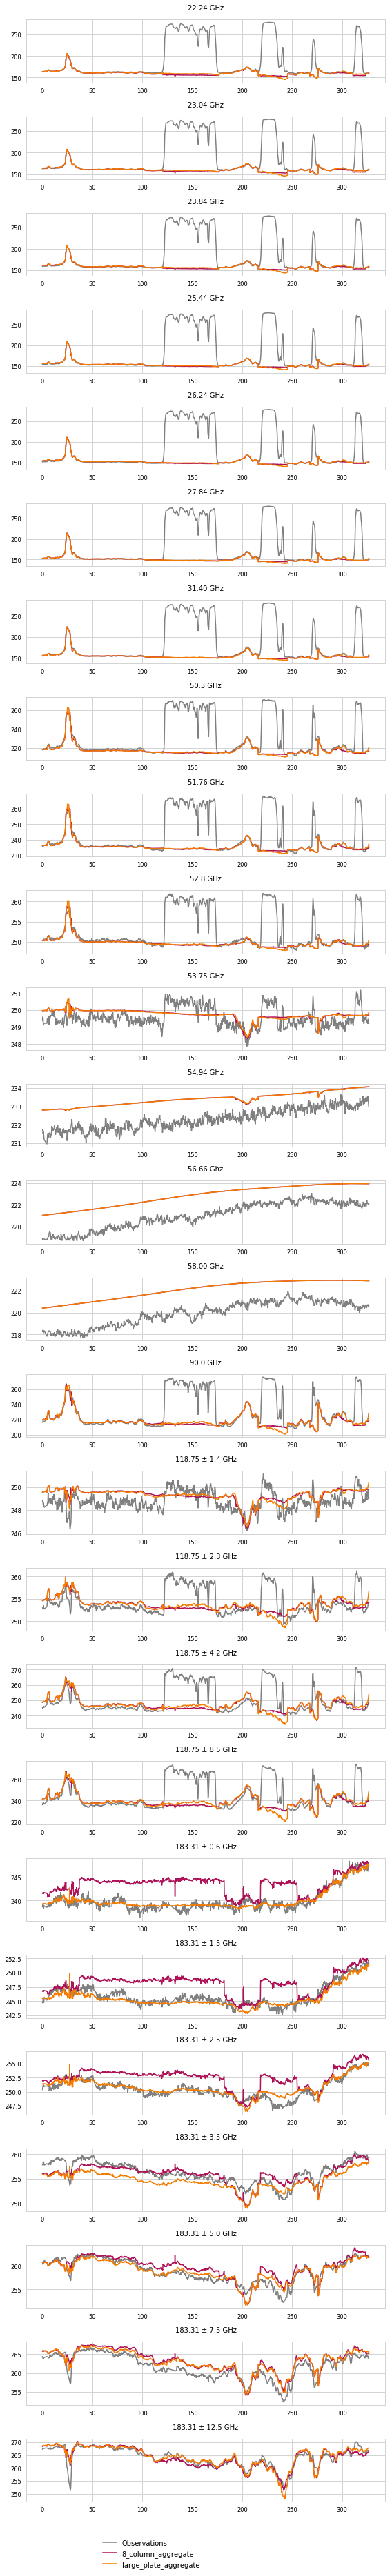

In [18]:
from joint_flight.data import hamp

n = 26
f, axs = plt.subplots(26, 1, figsize = (8,  2 * n))

channel_names_hamp = ["22.24 GHz", "23.04 GHz", "23.84 GHz", "25.44 GHz",   \
                      "26.24 GHz", "27.84 GHz", "31.40 GHz", "50.3 GHz", "51.76 GHz", \
                      "52.8 GHz", "53.75 GHz", "54.94 GHz", "56.66 Ghz", "58.00 GHz", \
                      "90.0 GHz"] + ["118.75 ± 8.5 GHz", "118.75 ± 4.2 GHz", "118.75 ± 2.3 GHz", \
                      "118.75 ± 1.4 GHz"][::-1]  \
                      + ["183.31 ± 12.5 GHz", "183.31 ± 7.5 GHz", "183.31 ± 5.0 GHz", \
                       "183.31 ± 3.5 GHz", "183.31 ± 2.5 GHz", "183.31 ± 1.5 GHz",  \
                       "183.31 ± 0.6 GHz"][::-1]

y = results["large_plate_aggregate"]["y_hamp_passive"]
mask = np.all(y < 1e9, axis = 1)
x = hamp.d[:-1][mask]

for i in range(n):
    ax = axs[i]
    ax.plot(x, y[mask, i], c = "gray", label = "Observations")
    
for shape in ["8_column_aggregate", "large_plate_aggregate"]:
    yf = results[shape]["yf_hamp_passive"]
    mask = np.all(yf < 1e9, axis = 1)
    x  = hamp.d[:-1][mask]
    for i in range(n):
        ax = axs[i]
        ax.set_title(channel_names_hamp[i])
        ax.plot(x, yf[mask, i], label = shape)
ax.legend(bbox_to_anchor = [0.5, -0.5])
plt.tight_layout()

f.savefig("retrieval_fits_hamp.pdf")

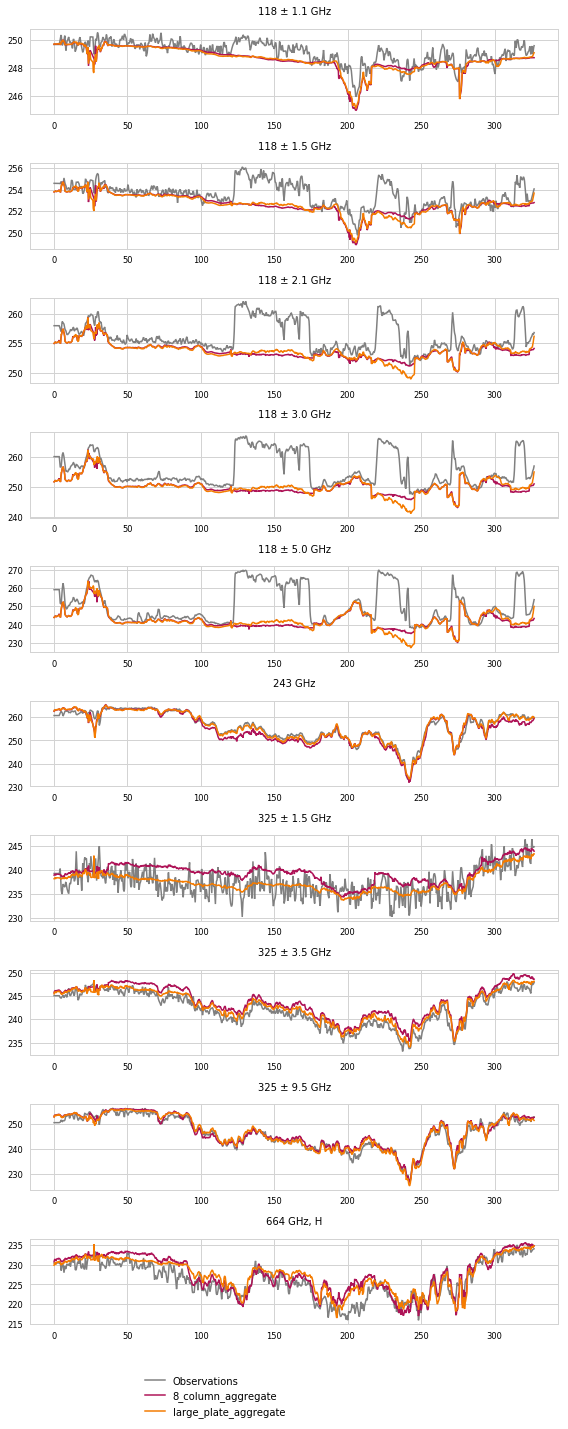

In [17]:
from joint_flight.data import hamp

n = 10
f, axs = plt.subplots(n, 1, figsize = (8,  2 * n))

channel_names_ismar = ["118 ± 1.1 GHz", "118 ± 1.5 GHz", "118 ± 2.1 GHz", "118 ± 3.0 GHz", "118 ± 5.0 GHz", \
                       "243 GHz", "325 ± 1.5 GHz", "325 ± 3.5 GHz", "325 ± 9.5 GHz", "664 GHz, H"]

y = results["large_plate_aggregate"]["y_ismar"]
mask = np.all(y < 1e9, axis = 1)
x = hamp.d[:-1][mask]

for i in range(n):
    ax = axs[i]
    ax.plot(x, y[mask, i], c = "gray", label = "Observations")
    
for shape in ["8_column_aggregate", "large_plate_aggregate"]:
    yf = results[shape]["yf_ismar"]
    mask = np.all(yf < 1e9, axis = 1)
    x  = hamp.d[:-1][mask]
    for i in range(n):
        ax = axs[i]
        ax.set_title(channel_names_ismar[i])
        ax.plot(x, yf[mask, i], label = shape)
ax.legend(bbox_to_anchor = [0.5, -0.5])

plt.tight_layout()
f.savefig("retrieval_fits_ismar.pdf")

## Retrieval residuals

In [37]:
import seaborn as sns
sns.reset_orig()

In [30]:
dy = yf[mask, :] - y[mask, :]

In [44]:
data

,dy,shape
0,"[0.543801361065988, 0.4988145104248076, 0.0806...",large_plate_aggregate
1,"[0.7545651000223472, 0.6556827553390576, 0.473...",large_plate_aggregate
2,"[0.977518977553018, 0.5763571302925925, 0.5540...",large_plate_aggregate
3,"[-2.000363885410792, -2.037472181668363, -2.02...",large_plate_aggregate
4,"[0.38307012555378606, 0.21030706633126783, 0.1...",large_plate_aggregate
5,"[1.5992673127545345, 1.7707045104743315, 2.120...",large_plate_aggregate
6,"[1.1748330976487296, 1.1904058708674938, 1.256...",large_plate_aggregate
7,"[1.9703727062356506, 2.3467312594540886, 2.419...",large_plate_aggregate
8,"[-1.1115584609703433, -1.0166467495053837, -0....",large_plate_aggregate
9,"[0.38565679883203074, 0.6912075465668863, 0.77...",large_plate_aggregate


In [46]:
dy.ravel()

masked_array(
  data=[[-0.14571498,  1.08995819,  1.99841351, ...,  0.36226525,
          1.46861266,  1.02734517],
        [-0.07877085,  1.32112999,  2.13666696, ...,  0.21338741,
          1.67083406,  1.07814248],
        [ 0.10731736,  1.26250857,  2.27373749, ...,  0.14967866,
          2.04037978,  1.15953988],
        ...,
        [-1.67956118, -0.5145807 ,  0.06524569, ...,  0.26629389,
          1.24024132, -0.66848387],
        [-1.97843334, -0.70645667,  0.05862025, ..., -0.18639914,
          1.19933748, -0.30427345],
        [-2.09532513, -0.87451089, -0.26643453, ..., -0.04236175,
          1.34860703, -0.20866178]],
  mask=False,
  fill_value=1e+20)

In [66]:
data

,channel,dy,shape
0,19,0.543801,1
1,19,0.498815,1
2,19,0.080670,1
3,19,0.795891,1
4,19,0.906305,1
5,19,0.879616,1
6,19,0.384566,1
7,19,0.558788,1
8,19,0.557431,1
9,19,0.571746,1


In [80]:
y  = results[shape]["y_hamp_radar"]
yf = results[shape]["yf_hamp_radar"]
mask = np.all(yf < 1e9, axis = 1)
print(mask)
dy = yf[mask, :] - y[mask, :]
dy.max()

[ True  True  True ...  True  True  True]


11.094882379759824

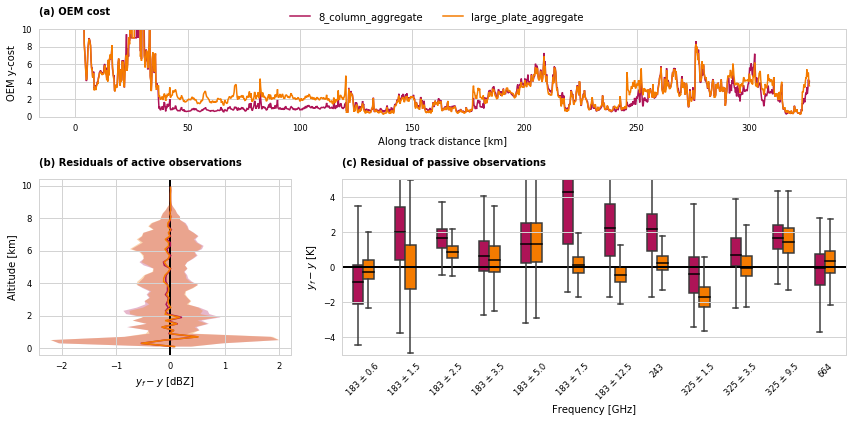

In [99]:
from matplotlib.gridspec import GridSpec
import pandas as pd

plt.figure(figsize = (12, 6))
gs = GridSpec(2, 2, width_ratios = [0.5, 1.0], height_ratios = [0.5, 1.0])

ax = plt.subplot(gs[0, :])

for shape in ["8_column_aggregate", "large_plate_aggregate"]:
    diagnostics = results[shape]["diagnostics"]
    ax.plot(hamp.d[:-1], diagnostics[:, 2], label = shape)
    
ax.set_title("(a) OEM cost", loc = "left", fontweight = "bold")
ax.set_ylim([0, 10])
ax.set_xlabel("Along track distance [km]")
ax.set_ylabel("OEM y-cost")
ax.legend(ncol = 2, bbox_to_anchor = (0.3, 1.3))

#
# RADAR errors
#

ax = plt.subplot(gs[1, 0])
ax.axvline(0, lw = 2, c = "k")

for shape in ["8_column_aggregate", "large_plate_aggregate"]:
    y  = results[shape]["y_hamp_radar"]
    yf = results[shape]["yf_hamp_radar"]
    mask = np.all(yf < 1e9, axis = 1)
    dy = yf[mask, :] - y[mask, :]
    
    dy_mean  = np.mean(dy.data, axis = 0)
    dy_sigma = np.std(dy.data, axis = 0)

    y = np.linspace(0.1, 9.9, 50)
    ax.plot(dy_mean, y, label = shape)
    ax.fill_betweenx(y, dy_mean - dy_sigma, dy_mean + dy_sigma, alpha = 0.3)
    
ax.set_ylabel("Altitude [km]")
ax.set_xlabel("$y_f - y$ [dBZ]")
ax.set_title("(b) Residuals of active observations", loc = "left", fontweight = "bold")
#
# Boxplot
#


ax = plt.subplot(gs[1, 1])

indices = [list(range(19, 26)), [5, 6, 7, 8, 9]]
frequencies = [["183 ± 0.6", "183 ± 1.5", "183 ± 2.5", "183 ± 3.5", "183 ± 5.0", "183 ± 7.5", "183 ± 12.5"], \
               ["243", "325 ± 1.5", "325 ± 3.5", "325 ± 9.5", "664"]]


dys = []
shapes = []
channels = []
for si, shape in enumerate(["8_column_aggregate", "large_plate_aggregate"]):
    
    yf = results[shape]["yf_hamp_passive"]
    y  = results[shape]["y_hamp_passive"]
    mask = np.all(y < 1e9, axis = 1)
    dy = yf[mask, :] - y[mask, :]
    for i in indices[0]:
        dys +=  [dy[:, i].ravel()]
        shapes += int(mask.sum()) * [shape]
        channels += int(mask.sum()) * [i]
        
    yf = results[shape]["yf_ismar"]
    y  = results[shape]["y_ismar"]
    mask = np.all(y < 1e9, axis = 1)
    dy = yf[mask, :] - y[mask, :]
    for i in indices[1]:
        dys += [dy[:, i].ravel()]
        shapes += int(mask.sum()) * [shape]
        channels += int(mask.sum()) * [i]
        
dys = np.concatenate(dys, axis = 0).ravel()
data = {"dy" : dys, "shape" : shapes, "channel" : channels}
data = pd.DataFrame(data)
        
ax.axhline(0, lw = 2, c = "k")
sns.boxplot(x = "channel", y = "dy", hue = "shape", data = data, showfliers = False, medianprops = {"color" : "k"}, saturation = 1, width = 0.5)
ax.get_legend().remove()
ax.set_ylim([-5, 5])
ax.set_ylabel("$y_f - y$ [K]")
ax.set_title("(c) Residual of passive observations", loc = "left", fontweight = "bold")

labels = frequencies[0] + frequencies[1]
ax.set_xticklabels(labels, rotation = 45)
ax.set_xlabel("Frequency [GHz]")

plt.tight_layout()
f.savefig("../plots/fit_overview.pdf")

## Retrieved Hydrometeor content

In [101]:
from scipy.special import gamma

md = results["large_plate_aggregate"]["ice_md"]
n0 = results["large_plate_aggregate"]["ice_n0"]
c   = gamma(4.0) / 4
rho = 917.0

dm = (6.0 / (np.pi * rho * c) * md / n0) ** 0.25

/home/simon/build/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less
/home/simon/src/matplotlib/lib/matplotlib/colors.py:998: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


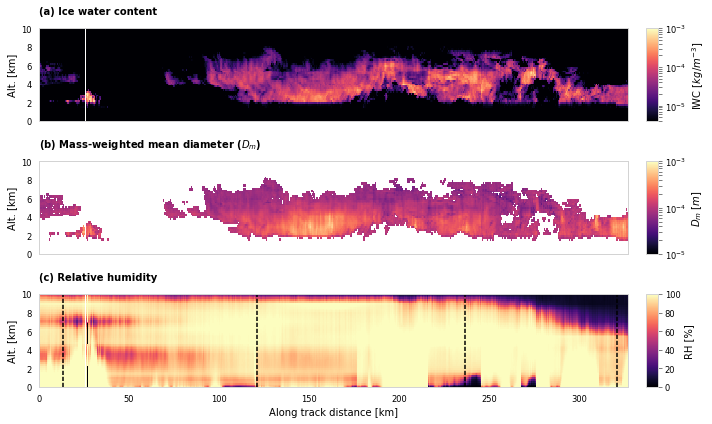

In [103]:
from matplotlib.colors import LogNorm, Normalize
from joint_flight.plots import grid_to_edges
from joint_flight.data import hamp
from joint_flight.data.in_situ import faam

plt.figure(figsize = (10, 6))
gs = GridSpec(3, 2, width_ratios = [1.0, 0.02])

x = hamp.d[:-1]
y = np.linspace(0, 13, 66)
xx, yy = np.meshgrid(x, y)
xx = grid_to_edges(xx)
yy = grid_to_edges(yy)
norm = LogNorm(vmin = 4e-6, vmax = 1e-3)

#
# 
#

ax = plt.subplot(gs[0, 0])
ax.set_title("(a) Ice water content", loc = "left", fontweight = "bold")
img = ax.pcolormesh(xx, yy, md.T , norm = norm)
plt.colorbar(img, cax = plt.subplot(gs[0, 1]), label = "IWC [$kg/m^{-3}$]")
ax.set_ylim([0, 10])
ax.set_xticks([])
ax.set_ylabel("Alt. [km]")

#
# D_m
#

dm_norm = LogNorm(vmin = 1e-5, vmax = 1e-3)
ax = plt.subplot(gs[1, 0])
ax.set_title("(b) Mass-weighted mean diameter ($D_m$)", loc = "left", fontweight = "bold")
dm[md < 5e-6] = np.nan
img = ax.pcolormesh(xx, yy, dm.T, norm = dm_norm)
plt.colorbar(img, cax = plt.subplot(gs[1, 1]), label = "$D_m$ [$m$]")
ax.set_ylim([0, 10])
ax.set_xticks([])
ax.set_ylabel("Alt. [km]")

#
# Relative humidity
#

ax = plt.subplot(gs[2, 0])
rh_norm = Normalize(vmin = 0, vmax = 100)
rh = results["large_plate_aggregate"]["rh"]
ax.set_ylim([0, 10])
ax.set_title("(c) Relative humidity ", loc = "left", fontweight = "bold")
for d in faam.ds_d:
    ax.axvline(d, c = "k", ls = "--")
img = ax.pcolormesh(xx, yy, 100.0 * rh.T , norm = rh_norm)
plt.colorbar(img, cax = plt.subplot(gs[2, 1]), label = "RH [%]")


ax.set_ylabel("Alt. [km]")
ax.set_xlabel("Along track distance [km]")

plt.tight_layout()
f.savefig("hmc")

## In-situ IWC

In [104]:
from joint_flight.data import hamp
from joint_flight.data.in_situ import faam
from scipy.interpolate import RegularGridInterpolator

from scipy.signal import convolve
k = np.ones(40) / 40.0

#
# Nevzorov probe data
#

nev_z   = np.convolve(faam.nev_z, k)
hmc_nev = np.convolve(faam.twc_ice / 1e3, k)
hmc_nev2 = np.convolve((faam.twc_ice / 1e3) ** 2, k) 
hmc_nev_sigma = np.sqrt(hmc_nev2 - hmc_nev ** 2)

#
# 8 Column aggregate
#
z   = np.linspace(0, 13e3, 66)
hmc_8ca = results["8_column_aggregate"]["ice_md"]
f = RegularGridInterpolator((hamp.d[:-1], z), hmc_8ca)
hmc_8ca = np.convolve(f((faam.nev_d, faam.nev_z)), k)
hmc_8ca_ro = results["8_column_aggregate"]["ice_md_ro"]
f = RegularGridInterpolator((hamp.d[:-1], z), hmc_8ca_ro)
hmc_8ca_ro = np.convolve(f((faam.nev_d, faam.nev_z)), k)

#
# Large plate aggregate
#
z   = np.linspace(0, 13e3, 66)
hmc_lpa = results["large_plate_aggregate"]["ice_md"]
f = RegularGridInterpolator((hamp.d[:-1], z), hmc_lpa)
hmc_lpa = np.convolve(f((faam.nev_d, faam.nev_z)), k)
hmc_lpa_ro = results["large_plate_aggregate"]["ice_md_ro"]
f = RegularGridInterpolator((hamp.d[:-1], z), hmc_lpa_ro)
hmc_lpa_ro = np.convolve(f((faam.nev_d, faam.nev_z)), k)

#
# Large column aggregate
#
z   = np.linspace(0, 13e3, 66)
hmc_lca = results["large_column_aggregate"]["ice_md"]
f = RegularGridInterpolator((hamp.d[:-1], z), hmc_lca)
hmc_lca = np.convolve(f((faam.nev_d, faam.nev_z)), k)
hmc_lca_ro = results["large_column_aggregate"]["ice_md_ro"]
f = RegularGridInterpolator((hamp.d[:-1], z), hmc_lca_ro)
hmc_lca_ro = np.convolve(f((faam.nev_d, faam.nev_z)), k)

## Only RADAR only

In [25]:
dx_nev.max()

2.357824737120844e-09

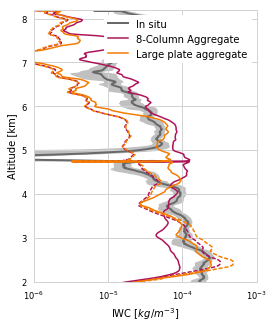

In [110]:
f, ax = plt.subplots(1, 1, figsize = (4, 5))
i_start = 100
i_end   = 1600

x_nev  = hmc_nev[i_start : i_end]
dx_nev = hmc_nev_sigma[i_start : i_end]
y = nev_z[i_start : i_end] / 1e3

ax.fill_betweenx(y, x_nev - dx_nev, x_nev + dx_nev, color = "silver")
ax.plot(x_nev, y, c = "dimgrey", lw = 2, label = "In situ")

# 8-Column Aggregate
ax.plot(hmc_8ca[i_start : i_end], y, c = "C0", label = "8-Column Aggregate")
ax.plot(hmc_8ca_ro[i_start : i_end], y, ls = "--", c = "C0")

# Large plate aggregate
ax.plot(hmc_lpa[i_start : i_end], y, c = "C1", label = "Large plate aggregate")
ax.plot(hmc_lpa_ro[i_start : i_end], y, c = "C1", ls = "--")

# Large column aggregate
#ax.plot(hmc_lca[i_start : i_end], y, c = "C1")
#ax.plot(hmc_lca_ro[i_start : i_end], y, c = "C1", ls = "--")



ax.set_ylabel("Altitude [km]")

ax.legend()
ax.set_xlabel("IWC [$kg/m^{-3}$]")
ax.set_xscale("log")
ax.set_xlim(1e-6, 1e-3)
ax.set_ylim(2, 8.2) 
f.savefig("../plots/iwc_in_situ.pdf", bbox_inches = "tight")

(2, 8.2)

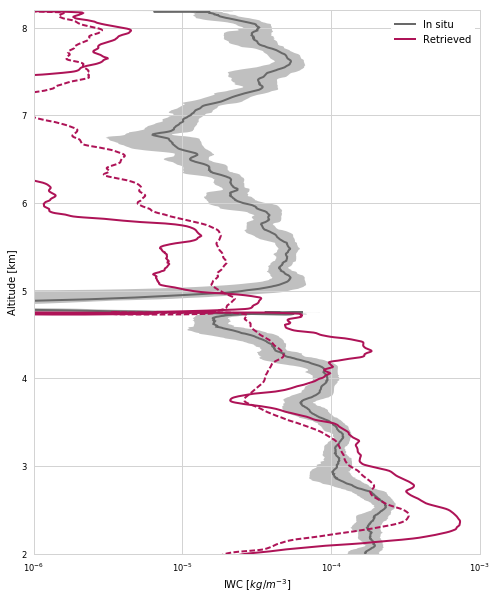

In [12]:
f, ax = plt.subplots(1, 1, figsize = (8, 10))
i_start = 100
i_end   = 1600

x_nev  = iwc_nev_avg[i_start : i_end]
dx_nev = iwc_nev_sd[i_start : i_end]
x_ret  = iwc_ret_avg[i_start : i_end]
dx_ret = iwc_ret_sd[i_start : i_end]
x_ret_ro  = iwc_ret_ro_avg[i_start : i_end]
y      = z_avg[i_start : i_end] / 1e3

ax.fill_betweenx(y, x_nev - dx_nev, x_nev + dx_nev, color = "silver")
ax.plot(x_nev, y, c = "dimgrey", lw = 2, label = "In situ")

#ax.fill_betweenx(y, x_ret - dx_ret, x_ret + dx_ret, alpha = 0.5, color = "C0")
ax.plot(x_ret, y, c = "C0", lw = 2, label = "Retrieved")

ax.plot(x_ret_ro, y, c = "C0", ls = "--", lw = 2, label = "Retrieved")

#ax.plot(x_ret_ro, y, c = "C1", lw = 2)

ax.set_ylabel("Altitude [km]")

ax.legend()
ax.set_xlabel("IWC [$kg/m^{-3}$]")
ax.set_xscale("log")
ax.set_xlim(1e-6, 1e-3)
ax.set_ylim(2, 8.2) 

(1e-06, 0.001)

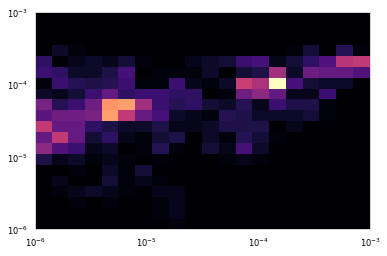

In [13]:
bins = np.logspace(-6, -3, 21)
img, _, _ = np.histogram2d(faam.twc_ice / 1e3, hmc_nev, bins =bins)
plt.pcolormesh(bins, bins, img)
plt.xscale("log")
plt.xlim([1e-6, 1e-3])
plt.yscale("log")
plt.ylim([1e-6, 1e-3])

## In-situ RH

In [14]:
from joint_flight.data.in_situ import faam
from joint_flight.data import era5

faam.ds_d
rh_inds = [np.argmin(np.abs(hamp.d - d)) for d in faam.ds_d]

In [15]:
faam.ds_d

[13.181170274373713, 121.2507738086377, 236.2003521113417, 320.6613386257547]

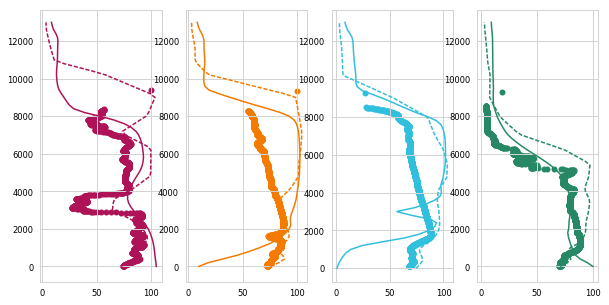

In [16]:
f, axs = plt.subplots(1, 4, figsize = (10, 5))
for i, j in enumerate(rh_inds):
    ax = axs[i]
    ax.plot(rh[j, :] * 100, z, c = "C" + str(i))
    ax.plot(era5.rh[j, :], z, c = "C" + str(i), ls = "--")
    ax.scatter(faam.ds_rh[i], faam.ds_z[i], c = "C" + str(i))

In [21]:
from typhon.physics import e_eq_ice_mk, e_eq_water_mk

/home/simon/build/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [22]:
for i, j in enumerate(rh_inds):
    print(i, j)

0 57
1 532
2 1037
3 1411
